# Predicting Car Prices

dataset documentation can be found [here](https://archive.ics.uci.edu/ml/datasets/automobile)

In [1]:
import pandas as pd
import numpy as np

columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=columns)

cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


# Reference

`normalized-losses`: relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year.

# Cleaning Data: Numeric Data Only

Since we will be using a K-Neareast Neighbors Machine Learning algorithm to predict car prices, we need to sort out which columns of our data are numeric. Luckily, the [documentation](https://archive.ics.uci.edu/ml/datasets/automobile) contains a download link to a .names file that has a list of the columns and which ones contain continuous values (including their ranges).

This is useful because some of the columns with continuous values are actually cast as a string in our dataframe, and some of the columns have integers but are not the kind of numeric representations we want for KNN.

In [2]:
# We'll make a new dataframe that only contains numeric columns
continuous_values_columns = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars_numeric = cars.copy()[continuous_values_columns]

cars_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
normalized-losses    205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-size          205 non-null int64
bore                 205 non-null object
stroke               205 non-null object
compression-rate     205 non-null float64
horsepower           205 non-null object
peak-rpm             205 non-null object
city-mpg             205 non-null int64
highway-mpg          205 non-null int64
price                205 non-null object
dtypes: float64(5), int64(4), object(6)
memory usage: 24.1+ KB


# Cleaning Data: Numeric Data Should be a Numeric Data Type

We don't want objects in our columns; we want int64 or float64. The first thing in our way is that missing attribute values are denoted by a `?`. Luckily, again the .names file in the [documentation](https://archive.ics.uci.edu/ml/datasets/automobile) has us covered, letting us know that this is perfectly intentional and probably consistent, so let's replace all `?`'s and see if we can convert everything to a float.

In [3]:
cars_numeric = cars_numeric.replace({'?': np.nan})
cars_numeric = cars_numeric.astype(float)
cars_numeric.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,13495.0
1,NaN,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0
2,NaN,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0
3,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0
4,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0


In [4]:
cars_numeric.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

This matches perfectly with what the documentation tells us, se we know we are on the right track.

# Cleaning Data: Removing/Replacing All Missing Values

First we have to decide how to deal with our missing values. Since our `price` column will be the target for our KNN algorithm, we can't accurately fill in the price since that is the objective of this project in the first place, and there aren't that many missing values anyway, we can safely remove any rows missing the price info.

In [5]:
cars_numeric.dropna(subset=['price'], inplace=True)
cars_numeric.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

Next, we'll check to see how many rows there are with two or more missing values.

In [6]:
null_row_counts = cars_numeric.isnull().sum(axis=1)
multi_null_rows = null_row_counts[null_row_counts > 1]
multi_null_rows

55     2
56     2
57     2
58     2
130    3
131    3
dtype: int64

We'll drop all of these rows.

In [7]:
cars_numeric.drop(multi_null_rows.index, axis=0, inplace=True)
cars_numeric.isnull().sum()

normalized-losses    35
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  0
stroke                0
compression-rate      0
horsepower            0
peak-rpm              0
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

Now we are left with our only missing values being in the `normalized-losses` column. It would be a shame to drop all 35 rows of good data that go with those missing values, so we'll fill those in with the average value for the column.

In [8]:
cars_numeric['normalized-losses'].fillna(
    cars_numeric['normalized-losses'].mean(), inplace=True,
)
cars_numeric.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

And next, we should normalize all of our data so that it ranges from 0 to 1, that way disproportionately large changes in certain columns won't be weighted as of higher importance.

The exception is the target column because we need the original values.

In [9]:
def normalize(df, features):
    result = df.copy()
    for feature_name in features:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return df

features = ['normalized-losses', 'wheel-base', 'length',
            'width', 'height', 'curb-weight', 'engine-size',
            'bore', 'stroke', 'compression-rate',
            'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg'
]

cars_numeric = normalize(cars_numeric, features)

cars_numeric

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.294764,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125000,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.294764,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125000,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.294764,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.125000,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.187500,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.062500,0.313084,0.551020,0.138889,0.157895,17450.0
5,0.294764,0.384840,0.540299,0.512821,0.441667,0.395268,0.283019,0.464286,0.633333,0.093750,0.289720,0.551020,0.166667,0.236842,15250.0
6,0.486911,0.559767,0.770149,0.948718,0.658333,0.525989,0.283019,0.464286,0.633333,0.093750,0.289720,0.551020,0.166667,0.236842,17710.0
7,0.294764,0.559767,0.770149,0.948718,0.658333,0.568658,0.283019,0.464286,0.633333,0.093750,0.289720,0.551020,0.166667,0.236842,18920.0
8,0.486911,0.559767,0.770149,0.948718,0.675000,0.619860,0.264151,0.421429,0.633333,0.081250,0.429907,0.551020,0.111111,0.105263,23875.0
10,0.664921,0.425656,0.532836,0.384615,0.541667,0.351823,0.177358,0.685714,0.347619,0.112500,0.247664,0.673469,0.277778,0.342105,16430.0


Hopefully that normalization was done correctly!!!

In [10]:
cars_numeric.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [11]:
for column in cars_numeric.columns:
    print(cars_numeric[column].max())
for column in cars_numeric.columns:
    print(cars_numeric[column].min())

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
45400.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5118.0


Looks correct.

And with that—we have a squeaky clean and polished dataset to use for some machine learning.

# Machine Learning: Univariate KNN

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(df, feature, target):
    # Split data into training and test data
    length = df.shape[0]
    df_train = df.iloc[:(length*3) // 4]
    df_test = df.iloc[(length*3) // 4:]
    # Train and Predict
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(df_train[feature], df_train[target])
    prediction = knn.predict(df_test[feature])
    # Calculate RMSE
    mse = mean_squared_error(df_test[target], prediction)
    rmse = mse ** (1/2)
    return rmse

features = ['normalized-losses', 'wheel-base', 'length',
            'width', 'height', 'curb-weight', 'engine-size',
            'bore', 'stroke', 'compression-rate',
            'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg'
]
target = 'price'


k5_univariate_rmse = {feature: knn_train_test(cars_numeric, [feature], target) for feature in features}
print(k5_univariate_rmse)
print('\n')
# Minimum RMSE row that performed best for the default k value:
print(min(k5_univariate_rmse, key=k5_univariate_rmse.get))

{'width': 3588.7225963383385, 'curb-weight': 2038.6268287596868, 'normalized-losses': 9827.62200335444, 'engine-size': 3564.610855024024, 'bore': 8327.983506472718, 'wheel-base': 6352.634733040187, 'highway-mpg': 2616.1674278631795, 'horsepower': 3983.234793327593, 'peak-rpm': 7352.0242747373, 'height': 6590.154368140276, 'city-mpg': 3416.9572079287627, 'length': 7167.613517049864, 'stroke': 7974.5191580714745, 'compression-rate': 5962.929579613411}


curb-weight


the `curb-weight` column performed the best when the value of k was `5`.

Next, we'll update our function to vary values of k.

We'll also separate the datasplitting into a function of its own

In [13]:
def data_split(df):
    # Set seed so that the row shuffling is consistent
    np.random.seed(1)
    # Randomize indices 
    shuffled_index = np.random.permutation(df.index)
    df_rand = df.reindex(shuffled_index)
    # Split rows 75% 25%
    length = df.shape[0]
    df_train = df_rand.iloc[:(length*3) // 4]
    df_test = df_rand.iloc[(length*3) // 4:]
    return (df_train, df_test)

def knn_train_test(df, k, feature, target):
    # Split data into training and test data
    df_train = data_split(df)[0]
    df_test = data_split(df)[1]
    # Train and Predict
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(df_train[feature], df_train[target])
    prediction = knn.predict(df_test[feature])
    # Calculate RMSE
    mse = mean_squared_error(df_test[target], prediction)
    rmse = mse ** (1/2)
    return rmse

k_values = range(1, 10, 2)

# We want to list all possible combinations
# of k values and features to use.
# Since our model is univariate, we only
# need combinations that are length 2
from itertools import product

k_feature_product = tuple(product(k_values, features))

rmse_evaluated = pd.DataFrame(
    data={
        'k_value': [k for k, feature in k_feature_product],
        'feature': [feature for k, feature in k_feature_product],
        'rmse': [
            knn_train_test(
            cars_numeric, k, [feature], target
            ) for k, feature in k_feature_product
        ]
    }
)

rmse_evaluated.sort_values('rmse').head()

,feature,k_value,rmse
6,engine-size,1,2579.307153
15,wheel-base,3,2720.826870
2,length,1,2786.243730
10,horsepower,1,3101.559252
20,engine-size,3,3159.057015


At this stage, we should attempt to quantify which features perform best at prediction, that way we can narrow down which features we should explore for use in multivariate models. We'll choose the five best features and we'll say a feature "performs well" if it has a low average RMSE value for all k values we are using.

In [14]:
rmse_evaluated.drop(columns='k_value').groupby(
    'feature').agg(np.mean).sort_values('rmse').head()

,rmse
feature,
engine-size,3297.824380
length,3590.090713
wheel-base,3754.958064
city-mpg,3844.973690
width,3894.302001


In [15]:
top5_features = tuple(rmse_evaluated.drop(columns='k_value').groupby(
    'feature').agg(np.mean).sort_values('rmse').head(5).index)
top5_features

('engine-size', 'length', 'wheel-base', 'city-mpg', 'width')

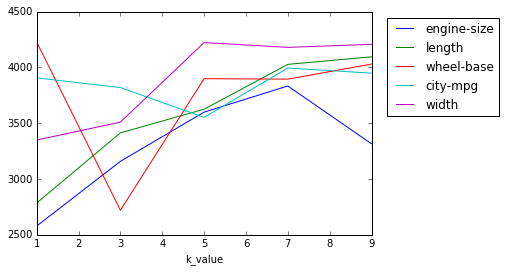

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

ax=plt.axes()
for feature in top5_features:
    rmse_evaluated.loc[rmse_evaluated['feature'] == feature].plot(x='k_value', y='rmse', ax=ax, label=feature)
ax.legend(bbox_to_anchor=(1.4, 1))

## Observations

# READ THIS AND FIX IT

In our univariate model, the `engine` column with a k value of `1` was the best predictor of price. This might make a good amount of sense, as engines are very expensive; cars tend to get more expensive as they get larger, and a requirement for a larger vehicle is a larger engine to move the load.

When we measure by a better heuristic such as "average RMSE over multiple k values", the top five features are: `engine-size`, `length`, `wheel-base`, `city-mpg`, and `width` in that order.


Next, we'll modify our `knn_train_test()` function to be multivariate; we'll let it use multiple columns, and we'll go back to using just a k value of 5.

# Machine Learning: Multivariate KNN

In [17]:
def knn_train_test(df, features, target):
    # Split data into training and test data
    data_splitted = data_split(df)
    df_train = data_splitted[0]
    df_test = data_splitted[1]
    # Train and Predict
    knn = KNeighborsRegressor(n_neighbors=5)
    knn.fit(df_train[features], df_train[target])
    prediction = knn.predict(df_test[features])
    # Calculate RMSE
    mse = mean_squared_error(df_test[target], prediction)
    rmse = mse ** (1/2)
    return rmse

# We want to make lists of best features
# that are lengths 2, 3, 4, and 5
# to use in our evaluations
best_features_combinations = [list(top5_features[:x]) for x in range(2, 6)]

rmse_evaluated = pd.DataFrame(
    data={
        'feature_list': [
            feature_list for feature_list in best_features_combinations
        ],
        'rmse': [
            knn_train_test(cars_numeric, feature_list, target) for feature_list in best_features_combinations
        ]
    }
)
rmse_evaluated.sort_values('rmse')

,feature_list,rmse
3,"[engine-size, length, wheel-base, city-mpg, wi...",2837.763094
1,"[engine-size, length, wheel-base]",2995.025292
0,"[engine-size, length]",3112.961770
2,"[engine-size, length, wheel-base, city-mpg]",3309.200520


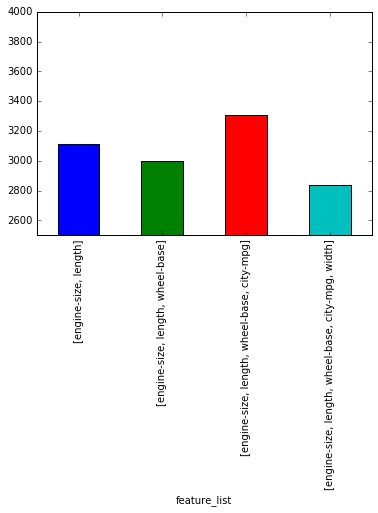

In [18]:
ax=plt.axes()

rmse_evaluated.plot.bar(x='feature_list', y='rmse', ax=ax)

ax.set_ylim(2500,4000)
ax.get_legend().remove()

## Observations

It seems that all 5 best feauters,`engine-size`, `length`, `wheel-base`, `city-mpg`, and `width` together, do best if er onlu use a k value of 5. We'd expect that more features would do better than a single feature, and this seems to be the case, though our 4 best features together performed the worst.

Next, we'll take the best three multivariate models we have so far and find the optimal k values for them.

# Machine Learning: KNN Hyperparameter Tuning

In [19]:
worst_model_feature_list = rmse_evaluated.sort_values('rmse').iloc[-1]['feature_list']

best_features_combinations.remove(
    worst_model_feature_list
)

In [20]:
best_features_combinations

[['engine-size', 'length'],
 ['engine-size', 'length', 'wheel-base'],
 ['engine-size', 'length', 'wheel-base', 'city-mpg', 'width']]

In [21]:
# Add back the ability to evaluate different k values


def knn_train_test(df, k, features, target):
    # Split data into training and test data
    data_splitted = data_split(df)
    df_train = data_splitted[0]
    df_test = data_splitted[1]
    # Train and Predict
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(df_train[features], df_train[target])
    prediction = knn.predict(df_test[features])
    # Calculate RMSE
    mse = mean_squared_error(df_test[target], prediction)
    rmse = mse ** (1/2)
    return rmse

# We'll combine our last two approaches
k_values = range(1, 26)
k_features_product = tuple(product(k_values, best_features_combinations))

rmse_evaluated = pd.DataFrame(
    data={
        'feature_list': [
            tuple(feature_list) for k_value, feature_list in k_features_product
        ],
        'k_value': [
            k_value for k_value, feature_list in k_features_product
        ],
        'rmse': [
            knn_train_test(cars_numeric, k_value, feature_list, target) for k_value, feature_list in k_features_product
        ]
    }
)
rmse_evaluated.sort_values('rmse')

,feature_list,k_value,rmse
2,"(engine-size, length, wheel-base, city-mpg, wi...",1,2087.123663
5,"(engine-size, length, wheel-base, city-mpg, wi...",2,2221.138071
8,"(engine-size, length, wheel-base, city-mpg, wi...",3,2489.256633
3,"(engine-size, length)",2,2526.611370
11,"(engine-size, length, wheel-base, city-mpg, wi...",4,2680.517411
10,"(engine-size, length, wheel-base)",4,2748.560012
7,"(engine-size, length, wheel-base)",3,2776.786882
9,"(engine-size, length)",4,2829.295415
14,"(engine-size, length, wheel-base, city-mpg, wi...",5,2837.763094
0,"(engine-size, length)",1,2892.471308


In [22]:
best_rmse_values = rmse_evaluated.drop(columns='k_value').groupby('feature_list').agg(min)['rmse']


list_of_dataframes = dfl = [rmse_evaluated.loc[rmse_evaluated['rmse'] == best_rmse_values[index]] for index in range(3)]


best_rmse_values = pd.concat([dfl[0], dfl[1], dfl[2]])
best_rmse_values.sort_values('rmse')

,feature_list,k_value,rmse
2,"(engine-size, length, wheel-base, city-mpg, wi...",1,2087.123663
3,"(engine-size, length)",2,2526.611370
10,"(engine-size, length, wheel-base)",4,2748.560012


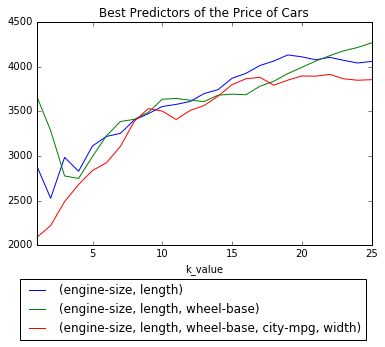

In [24]:
ax=plt.axes()
for feature_list in best_features_combinations:
    rmse_evaluated[rmse_evaluated['feature_list'].apply(len) == len(feature_list)].plot(x='k_value', y='rmse', ax=ax, label=tuple(feature_list))
ax.legend(bbox_to_anchor=(1, -0.125))
plt.title('Best Predictors of the Price of Cars')

## Observations

The optimal k values for the best two features, best 3 features, and best 5 features are `2`, `4`, and `1` respectively.

There isn't much difference between the k values that perform well. With this dataset, low k values have been performing consistently well.

It seems like with less data and with more relevant data, lower k values perform better. It could also just be random chance depending on how the data set is shuffled.

So as your amount of data increases and as the relevancy decreases, the optimal k value increases, and as the amount of data decreases and the relevancy increases, the optimal k value decreases.

# Further Studies

We didn't cover everything about KNN models in this notebook, but some further exploration might involve:

* Modify `knn_train_test()` to use k-fold cross validation
* Modify `knn_train_test()` to perform all data cleaning automatically.